In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, rdFingerprintGenerator
from rdkit.ML.Cluster import Butina
import os
import seaborn as sns

sns.set_style("dark")

<h4>Import zbioru danych cząsteczek testowanych na ludzkiej kinazie EGFR, przefiltrowanych zgodnie z regułą Lipinskiego z ćwiczenia 2.</h4>

In [3]:
EGFR_lipinski = pd.read_csv(os.path.join("..", "4_wirtualne_badania_przesiewowe", "EGFR_lipinski_distances.csv"))

In [4]:
EGFR_lipinski.head()

,passed,Molecular mass,LogP,H-Donors,H-Acceptors,molecule_name,canonical_smiles,pIC50,tanimoto_MACCS,tanimoto_Morgan,dice_MACCS,dice_Morgan
0,True,383.814,4.45034,3,4,CHEMBL68920,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,7.387216,0.472222,0.321839,0.641509,0.486957
1,True,369.432,4.77200,1,6,CHEMBL137635,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12,5.031517,0.449275,0.182796,0.620000,0.309091
2,True,283.287,2.31056,2,4,CHEMBL306988,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,3.301030,0.283784,0.091954,0.442105,0.168421
3,True,370.456,5.58790,1,5,CHEMBL47940,Nc1ncnc2c1c(-c1ccc(Oc3ccccc3)cc1)cn2C1CCCC1,5.494850,0.578125,0.105263,0.732673,0.190476
4,True,442.515,5.07900,3,3,CHEMBL432941,COc1cccc(-c2ccc3c(c2)NC(=O)/C3=C\c2[nH]c3c(c2C...,5.051587,0.474359,0.088496,0.643478,0.162602


In [5]:
EGFR_lipinski.shape

(667, 12)

<h4>Import fingerprintów wygenerowanych w ćwiczeniu 4.</h4>

In [6]:
maccs_fingerprints = pd.read_csv(os.path.join("..", "4_wirtualne_badania_przesiewowe", "maccs_fingerprints.csv"))
morgan_fingerprints = pd.read_csv(os.path.join("..", "4_wirtualne_badania_przesiewowe", "morgan_fingerprints.csv"))

In [7]:
maccs_fingerprints.head()

,aspirin,paracetamol,pseudoefedrin,sulfogaiacol,gefitinib
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [8]:
maccs_fingerprints.shape

(167, 5)

In [9]:
morgan_fingerprints.head()

,aspirin,paracetamol,pseudoefedrin,sulfogaiacol,gefitinib
0,0,0,0,0,0
1,0,0,1,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [10]:
morgan_fingerprints.shape

(2048, 5)

#### Obliczenie macierzy odległości Tanimoto, $distance=1-similarity$

In [11]:
def distance(smiles1: str, smiles2: str) -> float:
    morgan_generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
    return 1 - DataStructs.TanimotoSimilarity(morgan_generator.GetFingerprint(mol=Chem.MolFromSmiles(smiles1)), morgan_generator.GetFingerprint(mol=Chem.MolFromSmiles(smiles2)))

In [12]:
distance_matrix = np.zeros(shape=(EGFR_lipinski.shape[0],EGFR_lipinski.shape[0]))

In [13]:
for i in range(EGFR_lipinski.shape[0]):
    for j in range(EGFR_lipinski.shape[0]):
        distance_matrix[i, j] = distance(EGFR_lipinski["canonical_smiles"][i], EGFR_lipinski["canonical_smiles"][j])

In [20]:
distance_matrix

array([[0.        , 0.85869565, 0.90243902, ..., 0.80434783, 0.8877551 ,
        0.88990826],
       [0.85869565, 0.        , 0.88157895, ..., 0.80681818, 0.91666667,
        0.87378641],
       [0.90243902, 0.88157895, 0.        , ..., 0.84615385, 0.92771084,
        0.8255814 ],
       ...,
       [0.80434783, 0.80681818, 0.84615385, ..., 0.        , 0.8877551 ,
        0.82524272],
       [0.8877551 , 0.91666667, 0.92771084, ..., 0.8877551 , 0.        ,
        0.85714286],
       [0.88990826, 0.87378641, 0.8255814 , ..., 0.82524272, 0.85714286,
        0.        ]], shape=(667, 667))

#### Macierz dystansów jako heatmapa

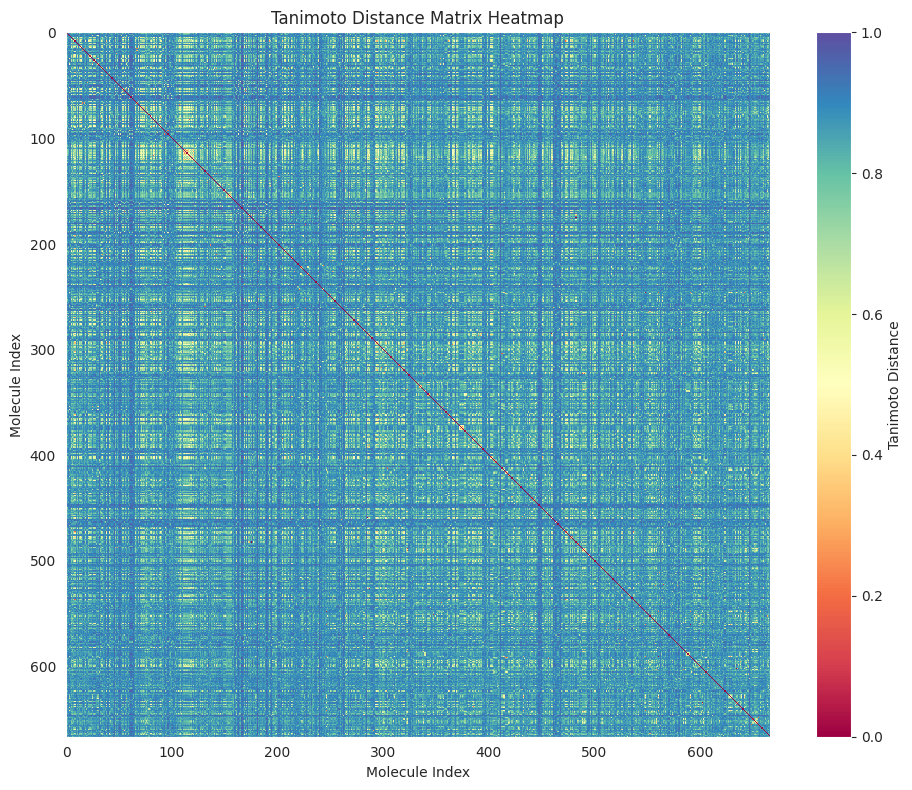

In [21]:
plt.figure(figsize=(10, 8))
# Create a heatmap with a colorbar
heatmap = plt.imshow(distance_matrix, cmap='Spectral', interpolation='nearest')
plt.colorbar(heatmap, label='Tanimoto Distance')

# Add labels and title
plt.title('Tanimoto Distance Matrix Heatmap')
plt.xlabel('Molecule Index')
plt.ylabel('Molecule Index')

# Add grid lines to better visualize each cell
plt.grid(False)

# Add tight layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()

#### Klastrowanie Butina

In [30]:
butina_cluster = Butina.ClusterData(distance_matrix, len(EGFR_lipinski), distThresh=0.4, isDistData=True)

In [31]:
butina_cluster

((293,
  8,
  38,
  41,
  80,
  89,
  119,
  204,
  264,
  294,
  302,
  319,
  320,
  362,
  384,
  472,
  536),
 (168,
  71,
  73,
  76,
  82,
  107,
  116,
  118,
  207,
  223,
  238,
  266,
  286,
  309,
  402,
  450,
  600),
 (213, 170, 214, 344, 380, 478),
 (83, 14, 54, 68, 85, 253, 275, 276),
 (590, 246, 414, 432, 548, 560, 628, 641),
 (323, 338, 418, 453, 488, 490, 586, 653),
 (474, 143, 285, 287, 390, 459, 526),
 (120, 111, 113, 115, 117),
 (551, 265, 331, 347, 360, 596),
 (210, 34, 142, 318),
 (479, 192, 436, 477),
 (261, 182, 216, 226, 252),
 (33,),
 (21, 224),
 (638, 297, 385, 595),
 (591, 415, 416, 417),
 (473,),
 (427, 355, 388, 529),
 (403,),
 (401,),
 (393, 392),
 (361,),
 (354, 25, 29, 357),
 (298, 317),
 (290, 55, 169, 660),
 (173, 175, 177, 482),
 (133, 56),
 (112, 114),
 (108,),
 (67, 15, 17, 66),
 (23, 7, 13, 22),
 (635, 602, 634),
 (623, 303),
 (603, 558, 584),
 (578, 523, 557),
 (559,),
 (552, 663),
 (499, 351, 391),
 (439, 421, 422),
 (431, 458, 622),
 (419, 300

#### Liczba singletonów i histogram rozmiarów klastrów

Number of singletons: 389 out of 479 clusters (81.21%)


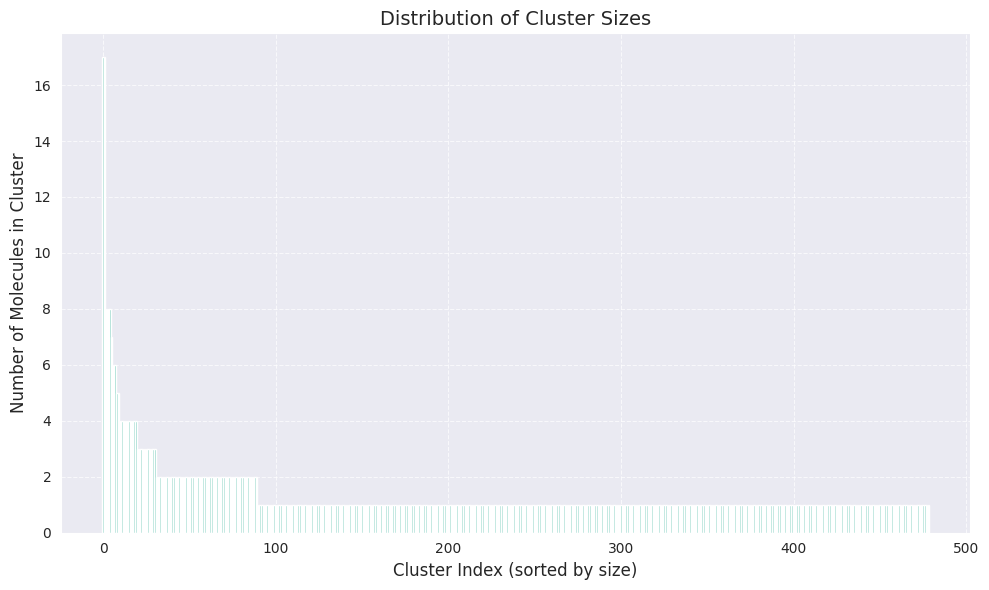

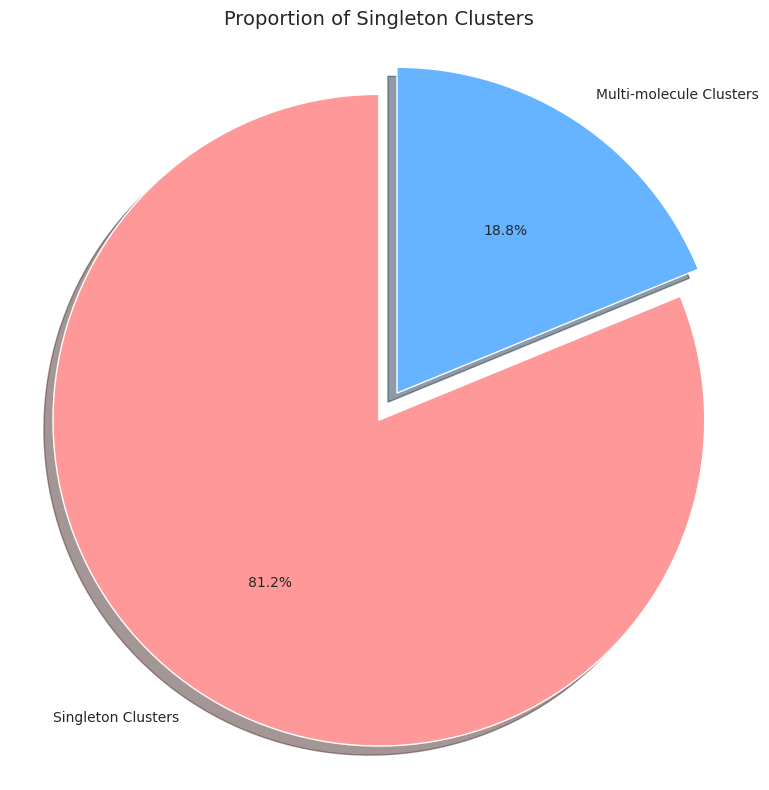

In [32]:
# Count the number of singletons (clusters with only one member)
singletons = sum(1 for cluster in butina_cluster if len(cluster) == 1)
total_clusters = len(butina_cluster)

print(f"Number of singletons: {singletons} out of {total_clusters} clusters ({singletons/total_clusters*100:.2f}%)")

# Plot distribution of cluster sizes
cluster_sizes = [len(cluster) for cluster in butina_cluster]

plt.figure(figsize=(10, 6))
plt.bar(range(len(cluster_sizes)), sorted(cluster_sizes, reverse=True))
plt.xlabel('Cluster Index (sorted by size)', fontsize=12)
plt.ylabel('Number of Molecules in Cluster', fontsize=12)
plt.title('Distribution of Cluster Sizes', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Create a pie chart of singleton vs non-singleton clusters
labels = ['Singleton Clusters', 'Multi-molecule Clusters']
sizes = [singletons, total_clusters - singletons]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)  # explode the 1st slice

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
    shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Proportion of Singleton Clusters', fontsize=14)
plt.tight_layout()
plt.show()

#### Wyświetlenie klastrów

/tmp/ipykernel_3806/1645143531.py:36: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


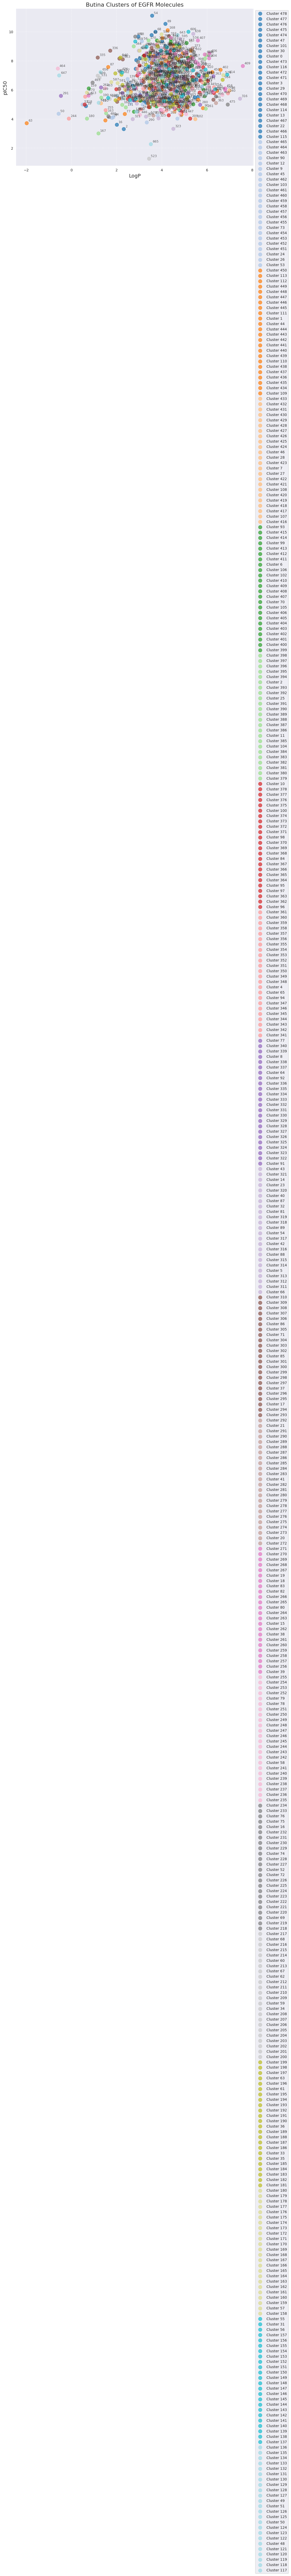

In [33]:
# Create a new column in the DataFrame to store cluster information
EGFR_lipinski['cluster_id'] = -1

# Populate the cluster IDs in the DataFrame
for cluster_id, cluster in enumerate(butina_cluster):
    for molecule_id in cluster:
        EGFR_lipinski.loc[molecule_id, 'cluster_id'] = cluster_id

# Plot the clusters
plt.figure(figsize=(12, 8))

# Get unique cluster IDs and set up a colormap
unique_clusters = EGFR_lipinski['cluster_id'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))

# Create a scatter plot with different colors for each cluster
for i, cluster_id in enumerate(unique_clusters):
    cluster_data = EGFR_lipinski[EGFR_lipinski['cluster_id'] == cluster_id]
    plt.scatter(cluster_data['LogP'], cluster_data['pIC50'], 
                c=[colors[i]], label=f'Cluster {int(cluster_id)}', 
                s=100, alpha=0.7)

# Add labels for each point
for i, row in EGFR_lipinski.iterrows():
    plt.annotate(i, (row['LogP'], row['pIC50']), 
                 fontsize=9, alpha=0.7,
                 xytext=(5, 5), textcoords='offset points')

plt.title('Butina Clusters of EGFR Molecules', fontsize=16)
plt.xlabel('LogP', fontsize=14)
plt.ylabel('pIC50', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
# plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('tab20')), 
#             label='Cluster ID', ticks=np.arange(len(unique_clusters)))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

#### Wyświetlenie struktur z największego klastra

The largest cluster has 17 molecules with cluster ID 0


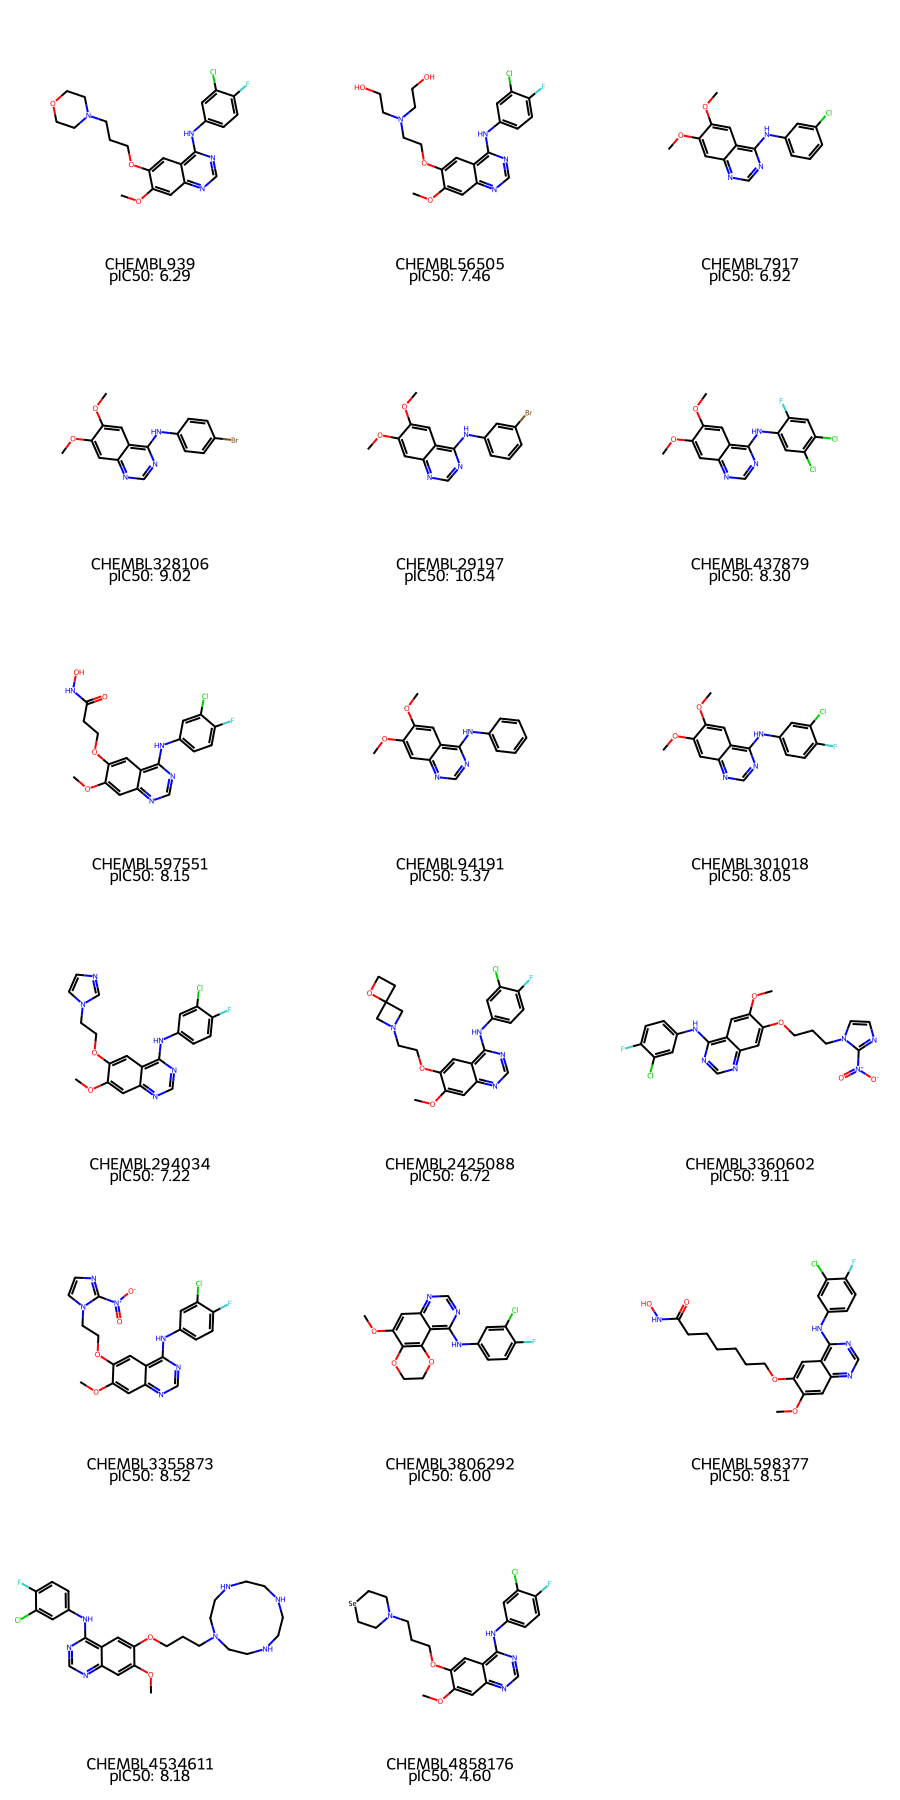


Molecules in this cluster:
CHEMBL939 - LogP: 4.28, pIC50: 6.29
CHEMBL56505 - LogP: 2.84, pIC50: 7.46
CHEMBL7917 - LogP: 4.04, pIC50: 6.92
CHEMBL328106 - LogP: 4.15, pIC50: 9.02
CHEMBL29197 - LogP: 4.15, pIC50: 10.54
CHEMBL437879 - LogP: 4.84, pIC50: 8.30
CHEMBL597551 - LogP: 3.45, pIC50: 8.15
CHEMBL94191 - LogP: 3.39, pIC50: 5.37
CHEMBL301018 - LogP: 4.18, pIC50: 8.05
CHEMBL294034 - LogP: 4.45, pIC50: 7.22
CHEMBL2425088 - LogP: 4.03, pIC50: 6.72
CHEMBL3360602 - LogP: 4.75, pIC50: 9.11
CHEMBL3355873 - LogP: 4.36, pIC50: 8.52
CHEMBL3806292 - LogP: 3.95, pIC50: 6.00
CHEMBL598377 - LogP: 5.01, pIC50: 8.51
CHEMBL4534611 - LogP: 3.03, pIC50: 8.18
CHEMBL4858176 - LogP: 4.80, pIC50: 4.60


In [34]:
# Find the largest cluster
largest_cluster_id = max(butina_cluster, key=len)[0]  # Get first element from largest cluster
largest_cluster = [i for i, row in EGFR_lipinski.iterrows() if row['cluster_id'] == EGFR_lipinski.loc[largest_cluster_id, 'cluster_id']]

print(f"The largest cluster has {len(largest_cluster)} molecules with cluster ID {EGFR_lipinski.loc[largest_cluster_id, 'cluster_id']}")

# Convert SMILES to RDKit molecules
molecules = [Chem.MolFromSmiles(EGFR_lipinski.loc[i, 'canonical_smiles']) for i in largest_cluster]

# Draw the molecules
img = Draw.MolsToGridImage(
    molecules,
    molsPerRow=3,
    subImgSize=(300, 300),
    legends=[f"{EGFR_lipinski.loc[i, 'molecule_name']}\npIC50: {EGFR_lipinski.loc[i, 'pIC50']:.2f}" for i in largest_cluster]
)

# Display the image
display(img)

# Print additional information about the molecules in this cluster
print("\nMolecules in this cluster:")
for i in largest_cluster:
    mol = EGFR_lipinski.loc[i]
    print(f"{mol['molecule_name']} - LogP: {mol['LogP']:.2f}, pIC50: {mol['pIC50']:.2f}")

In [35]:
import os

# Get molecules from the largest cluster
largest_cluster_mols = [Chem.MolFromSmiles(EGFR_lipinski.loc[i, 'canonical_smiles']) for i in largest_cluster]

# Add properties to the molecules
for i, mol_idx in enumerate(largest_cluster):
    mol = largest_cluster_mols[i]
    for prop in ['molecule_name', 'pIC50', 'LogP', 'Molecular mass', 'H-Donors', 'H-Acceptors']:
        value = EGFR_lipinski.loc[mol_idx, prop]
        mol.SetProp(prop, str(value))

# Create directory to save files if it doesn't exist
save_dir = "largest_cluster"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save molecules as SDF file
sdf_file = os.path.join(save_dir, "largest_cluster.sdf")
with Chem.SDWriter(sdf_file) as writer:
    for mol in largest_cluster_mols:
        writer.write(mol)

print(f"Saved {len(largest_cluster_mols)} molecules from the largest cluster to {sdf_file}")

# # Also save individual SD files
# for i, mol_idx in enumerate(largest_cluster):
#     mol = largest_cluster_mols[i]
#     mol_name = EGFR_lipinski.loc[mol_idx, 'molecule_name']
#     individual_file = os.path.join(save_dir, f"{mol_name}.sdf")
#     with Chem.SDWriter(individual_file) as writer:
#         writer.write(mol)

print(f"Also saved individual .sdf files for each molecule in the {save_dir} directory")

Saved 17 molecules from the largest cluster to largest_cluster/largest_cluster.sdf
Also saved individual .sdf files for each molecule in the largest_cluster directory
